# Reconstruction Method Comparison on Olivetti Faces Dataset

This notebook compares the regularized and unregularized least squares reconstruction methods on the Olivetti Faces Dataset.

We compute and compare the RMSE of various combinations of priors for sensor placement using TPGR optimizer and regularized reconstruction.
There are two types of priors: flat prior and decreasing prior. A flat prior is a scaled identity diagonal vector $\alpha \mathbf{d}_r$, where $r$ is the number of basis modes. A decreasing prior is a diagonal vector of normalized singular values of shape $(r)$, which are computed from the fitted data when `prior = 'decreasing'`. 
(These diagonal vectors are internally converted to diagonal matrices when needed.)

We also compare the RMSE of unregularized and regularized reconstruction for the QR and TPGR optimizers.

See the following reference for more information on Regularized Least Squares Reconstruction and Two-Point Greedy Optimizer ([link](https://arxiv.org/pdf/2307.11838))

`Klishin, Andrei A., J. Nathan Kutz and Krithika Manohar. Data-Induced Interactions of Sparse Sensors. 2023. arXiv:2307.11838 [cond-mat.stat-mech]`

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets

import pysensors as ps

In [2]:
def RMSE(X, Y):
    return np.sqrt(np.mean((Y - X) ** 2, axis=-1))

In [3]:
faces = datasets.fetch_olivetti_faces(shuffle=True, random_state=99)
X = faces.data

n_samples, n_features = X.shape

# Global centering
X = X - X.mean(axis=0)

# Local centering
X -= X.mean(axis=1).reshape(n_samples, -1)

The flat prior here is set to scaled identity matrix $4I_r$, where $r$ is the number of basis modes, and the noise is set to $0.01$.

The choice of prior and noise for the TPGR Optimizer and Regularized Reconstruction affect the RMSE curve for a given dataset, and must be chosen appropriately.

In [4]:
X_train, X_test = X[:320], X[320:]
r = 100
flat_prior = np.full(100, 4)
p_values = np.arange(2, 151)
noise = 0.01

Here, over a range of number of sensors (`p_values`), using flat prior TPGR optimizer, RMSE is computed for unregularized reconstruction, flat prior regularized reconstruction and decreasing prior regularized reconstruction.

In [ ]:
rmse_predict_f = []
rmse_reconstruct_ff = []
std_predict_f = []
std_reconstruct_ff = []
rmse_reconstruct_fd = []
std_reconstruct_fd = []

for p in p_values:
    model = ps.SSPOR(
        basis=ps.basis.SVD(n_basis_modes=r),
        optimizer=ps.optimizers.TPGR(n_sensors=p, noise=noise, prior=flat_prior),
    )
    model.fit(X_train)
    sensors = model.get_selected_sensors()
    x_test = X_test[:, sensors]
    X_test_residual = np.delete(X_test, sensors, axis=1)

    predicted_state = model.predict(x_test, method="unregularized")
    X_predicted_residual = np.delete(predicted_state, sensors, axis=1)
    rmse_predict_states = RMSE(X_test_residual, X_predicted_residual)
    rmse_predict = rmse_predict_states.mean()
    std_predict = rmse_predict_states.std(ddof=1)
    rmse_predict_f.append(rmse_predict)
    std_predict_f.append(std_predict)
    reconstructed_state = model.predict(x_test, prior=flat_prior, noise=noise)
    X_reconstructed_residual = np.delete(reconstructed_state, sensors, axis=1)
    rmse_reconstruct_states = RMSE(X_test_residual, X_reconstructed_residual)
    rmse_reconstruct = rmse_reconstruct_states.mean()
    std_reconstruct = rmse_reconstruct_states.std(ddof=1)
    rmse_reconstruct_ff.append(rmse_reconstruct)
    std_reconstruct_ff.append(std_reconstruct)

    reconstructed_state_ = model.predict(x_test, prior="decreasing", noise=noise)
    X_reconstructed_residual_ = np.delete(reconstructed_state_, sensors, axis=1)
    rmse_reconstruct_states_ = RMSE(X_test_residual, X_reconstructed_residual_)
    rmse_reconstruct_ = rmse_reconstruct_states_.mean()
    std_reconstruct_ = rmse_reconstruct_states_.std(ddof=1)
    rmse_reconstruct_fd.append(rmse_reconstruct_)
    std_reconstruct_fd.append(std_reconstruct_)

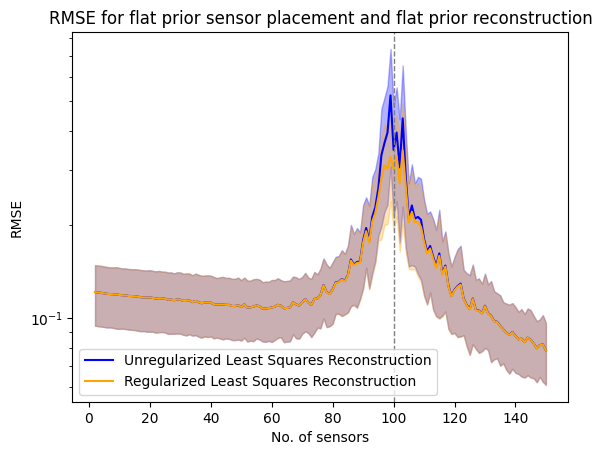

In [6]:
std_predict_f = np.array(std_predict_f)
std_reconstruct_ff = np.array(std_reconstruct_ff)
plt.plot(
    p_values,
    rmse_predict_f,
    label="Unregularized Least Squares Reconstruction",
    color="blue",
)
plt.fill_between(
    p_values,
    rmse_predict_f - std_predict_f,
    rmse_predict_f + std_predict_f,
    color="blue",
    alpha=0.3,
)
plt.xlabel("No. of sensors")
plt.ylabel("RMSE")
plt.yscale("log")
plt.plot(
    p_values,
    rmse_reconstruct_ff,
    label="Regularized Least Squares Reconstruction",
    color="orange",
)
plt.fill_between(
    p_values,
    rmse_reconstruct_ff - std_reconstruct_ff,
    rmse_reconstruct_ff + std_reconstruct_ff,
    color="orange",
    alpha=0.3,
)
plt.axvline(x=r, color="gray", linestyle="--", linewidth=1)
plt.title("RMSE for flat prior sensor placement and flat prior reconstruction")
plt.legend()
plt.show()

Here, over a range of number of sensors (`p_values`), using decreasing prior TPGR optimizer, RMSE is computed for unregularized reconstruction, flat prior regularized reconstruction and decreasing prior regularized reconstruction.

In [7]:
rmse_predict_d = []
rmse_reconstruct_df = []
std_predict_d = []
std_reconstruct_df = []
rmse_reconstruct_dd = []
std_reconstruct_dd = []

for p in p_values:
    model = ps.SSPOR(
        basis=ps.basis.SVD(n_basis_modes=r),
        optimizer=ps.optimizers.TPGR(n_sensors=p, noise=noise, prior="decreasing"),
    )
    model.fit(X_train)
    sensors = model.get_selected_sensors()
    x_test = X_test[:, sensors]
    X_test_residual = np.delete(X_test, sensors, axis=1)

    predicted_state = model.predict(x_test, method="unregularized")
    X_predicted_residual = np.delete(predicted_state, sensors, axis=1)
    rmse_predict_states = RMSE(X_test_residual, X_predicted_residual)
    rmse_predict = rmse_predict_states.mean()
    std_predict = rmse_predict_states.std(ddof=1)
    rmse_predict_d.append(rmse_predict)
    std_predict_d.append(std_predict)

    reconstructed_state = model.predict(x_test, prior=flat_prior, noise=noise)
    X_reconstructed_residual = np.delete(reconstructed_state, sensors, axis=1)
    rmse_reconstruct_states = RMSE(X_test_residual, X_reconstructed_residual)
    rmse_reconstruct = rmse_reconstruct_states.mean()
    std_reconstruct = rmse_reconstruct_states.std(ddof=1)
    rmse_reconstruct_df.append(rmse_reconstruct)
    std_reconstruct_df.append(std_reconstruct)

    reconstructed_state_ = model.predict(x_test, prior="decreasing", noise=noise)
    X_reconstructed_residual_ = np.delete(reconstructed_state_, sensors, axis=1)
    rmse_reconstruct_states_ = RMSE(X_test_residual, X_reconstructed_residual_)
    rmse_reconstruct_ = rmse_reconstruct_states_.mean()
    std_reconstruct_ = rmse_reconstruct_states_.std(ddof=1)
    rmse_reconstruct_dd.append(rmse_reconstruct_)
    std_reconstruct_dd.append(std_reconstruct_)

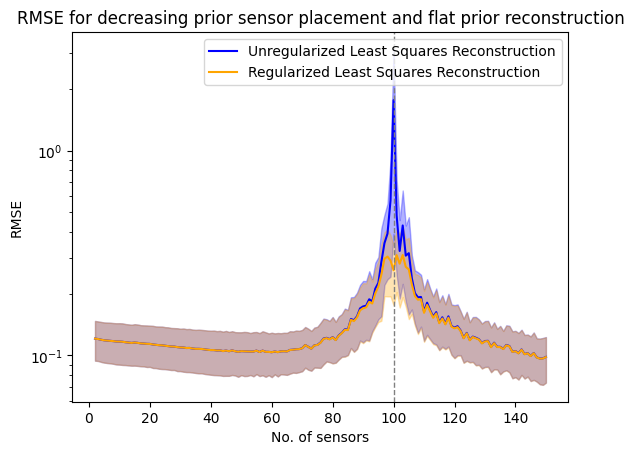

In [8]:
std_predict_d = np.array(std_predict_d)
std_reconstruct_df = np.array(std_reconstruct_df)
plt.plot(
    p_values,
    rmse_predict_d,
    label="Unregularized Least Squares Reconstruction",
    color="blue",
)
plt.fill_between(
    p_values,
    rmse_predict_d - std_predict_d,
    rmse_predict_d + std_predict_d,
    color="blue",
    alpha=0.3,
)
plt.xlabel("No. of sensors")
plt.ylabel("RMSE")
plt.yscale("log")
plt.plot(
    p_values,
    rmse_reconstruct_df,
    label="Regularized Least Squares Reconstruction",
    color="orange",
)
plt.fill_between(
    p_values,
    rmse_reconstruct_df - std_reconstruct_df,
    rmse_reconstruct_df + std_reconstruct_df,
    color="orange",
    alpha=0.3,
)
plt.axvline(x=r, color="gray", linestyle="--", linewidth=1)
plt.title("RMSE for decreasing prior sensor placement and flat prior reconstruction")
plt.legend()
plt.show()

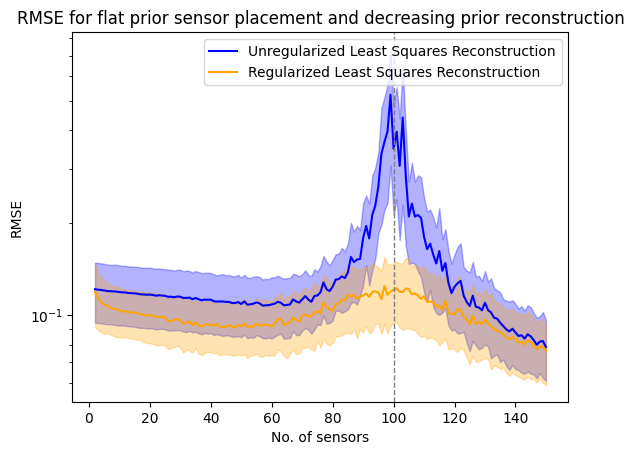

In [9]:
std_predict_f = np.array(std_predict_f)
std_reconstruct_fd = np.array(std_reconstruct_fd)
plt.plot(
    p_values,
    rmse_predict_f,
    label="Unregularized Least Squares Reconstruction",
    color="blue",
)
plt.fill_between(
    p_values,
    rmse_predict_f - std_predict_f,
    rmse_predict_f + std_predict_f,
    color="blue",
    alpha=0.3,
)
plt.xlabel("No. of sensors")
plt.ylabel("RMSE")
plt.yscale("log")
plt.plot(
    p_values,
    rmse_reconstruct_fd,
    label="Regularized Least Squares Reconstruction",
    color="orange",
)
plt.fill_between(
    p_values,
    rmse_reconstruct_fd - std_reconstruct_fd,
    rmse_reconstruct_fd + std_reconstruct_fd,
    color="orange",
    alpha=0.3,
)
plt.axvline(x=r, color="gray", linestyle="--", linewidth=1)
plt.title("RMSE for flat prior sensor placement and decreasing prior reconstruction")
plt.legend()
plt.show()

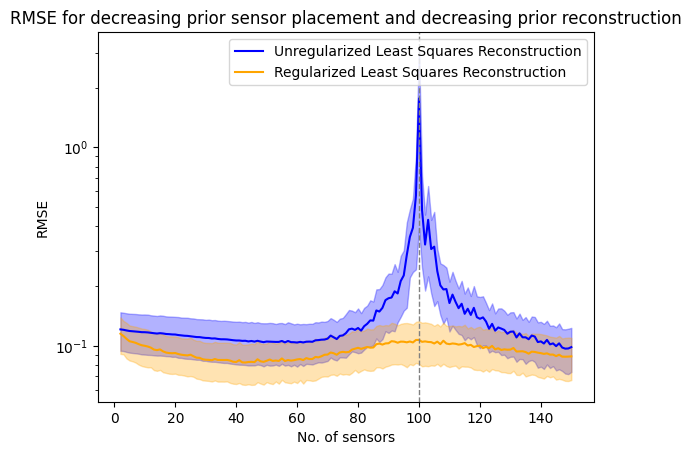

In [10]:
std_predict_d = np.array(std_predict_d)
std_reconstruct_dd = np.array(std_reconstruct_dd)
plt.plot(
    p_values,
    rmse_predict_d,
    label="Unregularized Least Squares Reconstruction",
    color="blue",
)
plt.fill_between(
    p_values,
    rmse_predict_d - std_predict_d,
    rmse_predict_d + std_predict_d,
    color="blue",
    alpha=0.3,
)
plt.xlabel("No. of sensors")
plt.ylabel("RMSE")
plt.yscale("log")
plt.plot(
    p_values,
    rmse_reconstruct_dd,
    label="Regularized Least Squares Reconstruction",
    color="orange",
)
plt.fill_between(
    p_values,
    rmse_reconstruct_dd - std_reconstruct_dd,
    rmse_reconstruct_dd + std_reconstruct_dd,
    color="orange",
    alpha=0.3,
)
plt.axvline(x=r, color="gray", linestyle="--", linewidth=1)
plt.title(
    "RMSE for decreasing prior sensor placement and decreasing prior reconstruction"
)
plt.legend()
plt.show()

Here, over a range of number of sensors (`p_values`), RMSE is computed for unregularized reconstruction for QR and decreasing prior TPGR optimizer and decreasing prior regularized reconstruction, again for QR and decreasing prior TPGR optimizer.

In [11]:
qr_rmse_predict_list = []
qr_std_predict_list = []
qr_rmse_reconstruct_list = []
qr_std_reconstruct_list = []

for p in p_values:
    model = ps.SSPOR(
        basis=ps.basis.SVD(n_basis_modes=r),
        n_sensors=p,
    )
    model.fit(X_train)
    sensors = model.get_selected_sensors()
    x_test = X_test[:, sensors]
    qr_X_test_residual = np.delete(X_test, sensors, axis=1)

    qr_predicted_state = model.predict(x_test, method="unregularized")
    qr_X_predicted_residual = np.delete(qr_predicted_state, sensors, axis=1)
    qr_rmse_predict_states = RMSE(qr_X_test_residual, qr_X_predicted_residual)
    qr_rmse_predict = qr_rmse_predict_states.mean()
    qr_std_predict = qr_rmse_predict_states.std(ddof=1)
    qr_rmse_predict_list.append(qr_rmse_predict)
    qr_std_predict_list.append(qr_std_predict)

    qr_reconstructed_state = model.predict(x_test, prior="decreasing", noise=noise)
    qr_X_reconstructed_residual = np.delete(qr_reconstructed_state, sensors, axis=1)
    qr_rmse_reconstruct_states = RMSE(qr_X_test_residual, qr_X_reconstructed_residual)
    qr_rmse_reconstruct = qr_rmse_reconstruct_states.mean()
    qr_std_reconstruct = qr_rmse_reconstruct_states.std(ddof=1)
    qr_rmse_reconstruct_list.append(qr_rmse_reconstruct)
    qr_std_reconstruct_list.append(qr_std_reconstruct)

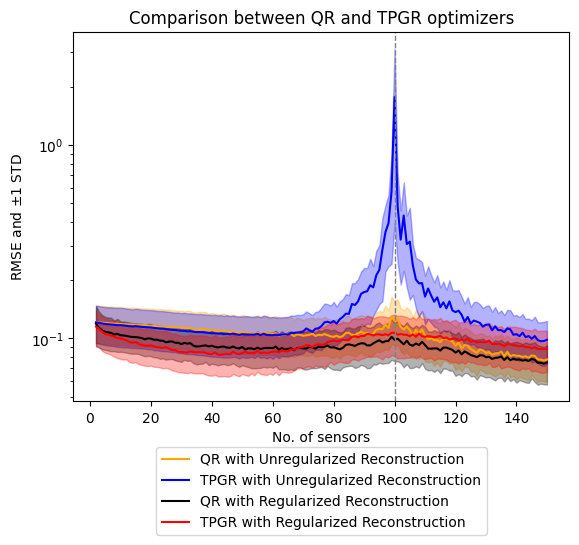

In [12]:
qr_rmse_reconstruct_list = np.array(qr_rmse_reconstruct_list)
qr_std_reconstruct_list = np.array(qr_std_reconstruct_list)
qr_rmse_predict_list = np.array(qr_rmse_predict_list)
qr_std_predict_list = np.array(qr_std_predict_list)
plt.figure()
plt.xlabel("No. of sensors")
plt.ylabel(r"RMSE and $\pm 1$ STD")
plt.yscale("log")
plt.plot(
    p_values,
    qr_rmse_predict_list,
    label="QR with Unregularized Reconstruction",
    color="orange",
)
plt.fill_between(
    p_values,
    qr_rmse_predict_list - qr_std_predict_list,
    qr_std_predict_list + qr_rmse_predict_list,
    color="orange",
    alpha=0.3,
)
plt.plot(
    p_values,
    rmse_predict_d,
    label="TPGR with Unregularized Reconstruction",
    color="blue",
)
plt.fill_between(
    p_values,
    rmse_predict_d - std_predict_d,
    rmse_predict_d + std_predict_d,
    color="blue",
    alpha=0.3,
)
plt.plot(
    p_values,
    qr_rmse_reconstruct_list,
    label="QR with Regularized Reconstruction",
    color="black",
)
plt.fill_between(
    p_values,
    qr_rmse_reconstruct_list - qr_std_reconstruct_list,
    qr_rmse_reconstruct_list + qr_std_reconstruct_list,
    color="black",
    alpha=0.3,
)
plt.plot(
    p_values,
    rmse_reconstruct_dd,
    label="TPGR with Regularized Reconstruction",
    color="red",
)
plt.fill_between(
    p_values,
    rmse_reconstruct_dd - std_reconstruct_dd,
    rmse_reconstruct_dd + std_reconstruct_dd,
    color="red",
    alpha=0.3,
)
plt.axvline(x=r, color="gray", linestyle="--", linewidth=1)
plt.title("Comparison between QR and TPGR optimizers")
plt.legend(loc="lower center", ncol=1, bbox_to_anchor=(0.5, -0.380))
plt.show()